In [26]:
#libraries
%matplotlib inline
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import ipywidgets as widgets

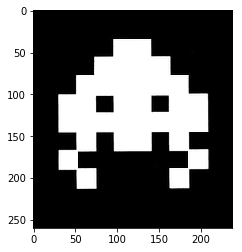

In [110]:
# Load an color image in grayscale
img = cv2.imread('test2.jpg',0)
img =255- img 
plt.imshow(img,cmap='gray')
plt.show()

In [28]:
def getRadians(angle):
    return (angle*math.pi)/180
def getBegining(x0,y0,radius,angle_rad):
    beginX = x0 + radius*math.sin(angle_rad)
    beginY= y0 +radius*math.cos(angle_rad)
    return beginX,beginY
def getEndPoint2(x0,y0,alpha,angle,radius,subst=0):
    angle_rad= getRadians(angle + 180 + alpha - subst)
    X = x0 + radius*math.sin(angle_rad)
    Y= y0 +radius*math.cos(angle_rad)
    return X,Y

In [55]:
def drawCircle(x0,y0,radius,ax):
    circle=plt.Circle((x0, y0),radius=radius,fill=False)
    ax.add_artist(circle)    

def drawLines(x0,y0,alpha,radius,n,l,ax):
    #Odległosc miedzy detektotami
    if(n>1):
        detectorDelta = float(2*l)/(n-1)
    else:
        detectorDelta=0
        l = 0
    beginX,beginY = getBegining(x0,y0,radius,getRadians(alpha))
    for i in range(n):
        endX,endY=getEndPoint2(x0,y0,alpha,l,radius,i*detectorDelta)
        line = plt.Line2D([beginX,endX],[beginY,endY])
        ax.add_artist(line)
    
def func(n,alpha,l):
    x0 =0.5; y0=0.5 ; radius =0.4
    plt.figure(figsize=(8,8))
    ax=plt.subplot(aspect='equal')
    drawCircle(x0,y0,radius,ax)
    drawLines(x0,y0,alpha,radius,n,l,ax)
    plt.show()
interact(func,n=(1,100),alpha =(0,359),l=(0,179));

interactive(children=(IntSlider(value=50, description='n', min=1), IntSlider(value=179, description='alpha', max=359), IntSlider(value=89, description='l', max=179), Output()), _dom_classes=('widget-interact',))

In [111]:
def getAB(x1,y1,x2,y2):
    a = np.array([[x1,1],[x2,1]])
    b = np.array([y1,y2])
    x = np.linalg.solve(a, b)
    return x

def getLines(x0,y0,alpha,radius,n,l):
    lines = []
    if(n>1):
        detectorDelta = float(2*l)/(n-1)
    else:
        detectorDelta=0
        l = 0
    bX,bY = getBegining(x0,y0,radius,getRadians(alpha))
    for i in range(n):
        eX,eY=getEndPoint2(x0,y0,alpha,l,radius,i*detectorDelta)
        if(eX!=bX and eY!=bY):
            lines.append(getAB(bX,bY,eX,eY))
    return lines
def getSum(img,line):
    xDim = img.shape[0]
    yDim = img.shape[1]
    a = line[0]
    b = line[1]
    detSum = 0
    for x in range(xDim):
        yValue = a*x + b
        yDown = math.floor(yValue)
        yUp = math.ceil(yValue)
        if(abs(yValue-yUp)>abs(yValue-yDown)):
            if(0<=yDown<yDim):
                detSum += img[x,yDown]
        else:
            if(0<=yUp<yDim):
                detSum += img[x,yUp]
    return detSum

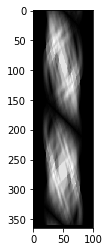

In [112]:
def drawSinogram(n,l_angle):
    sinogram =np.zeros(shape=(365,n))
    x0 = math.floor(img.shape[0]/2)
    y0 = math.floor(img.shape[1]/2)
    radius = (img.shape[0]*math.sqrt(2))/2
    for alpha in range(360):
        lines = getLines(x0,y0,alpha,radius,n,l_angle)
        for y in range(len(lines)):
            sinogram[alpha,y]=getSum(img,lines[y])
    plt.imshow(sinogram,cmap='gray')
    plt.show()
    return sinogram
sg =drawSinogram(100,100)
#interact(drawSinogram,n=(1,100),l_angle=(0,179));

[[21.06141242 23.01942837 22.47488956 ... 22.96771633 22.30967509
  22.89298692]
 [23.14388935 23.37969626 22.47779424 ... 22.42801865 22.30355767
  23.4373937 ]
 [21.96379855 24.97590396 21.97937818 ... 22.20814345 22.13138958
  24.3370952 ]
 ...
 [23.25686366 26.97581766 24.04394294 ... 25.67355441 23.8573835
  26.7823046 ]
 [24.89809384 26.60767194 24.78441537 ... 25.55270227 24.52070596
  26.49368539]
 [26.55538776 25.74929605 23.92903218 ... 26.58117777 23.88348157
  25.55107389]]


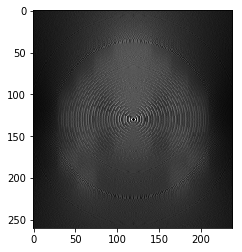

In [114]:
def drawLineOnImage(image,line,value):
    xDim = img.shape[0]
    yDim = img.shape[1]
    a = line[0]
    b = line[1]
    for x in range(xDim):
        yValue = a*x + b
        yDown = math.floor(yValue)
        yUp = math.ceil(yValue)
        if(abs(yValue-yUp)>abs(yValue-yDown)):
            if(0<=yDown<yDim):
                image[x,yDown] += value
        else:
            if(0<=yUp<yDim):
                image[x,yUp] +=value
    return image
def getImageFromSinogram(sinogram,n,l_angle):
    x0 = math.floor(img.shape[0]/2)
    y0 = math.floor(img.shape[1]/2)
    outputImage =np.zeros(shape=(img.shape[0],img.shape[1]))
    radius = (img.shape[0]*math.sqrt(2))/2
    for alpha in range(360):
        lines = getLines(x0,y0,alpha,radius,n,l_angle)
        for y in range(len(lines)):
            outputImage = drawLineOnImage(outputImage,lines[y],sinogram[alpha,y])
    outputImage[outputImage<256]=0
    outputImage = np.divide(outputImage,np.amax(outputImage))*255
    print(outputImage)
    plt.imshow(outputImage,cmap='gray')
    plt.show()
getImageFromSinogram(sg,100,100)
